In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer, one_hot
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import nltk
import numpy as np
import operator
from pipe import *

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Download data from the IMDB dataset using the Keras API. We want 10K vocab and a max length of 200 on reviews

In [2]:
vocab_size = 10000

from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = \
    imdb.load_data(num_words=vocab_size, maxlen=200)

Notionally select review 201 to visually inspect

In [3]:
review = 201

* Get the word index from IMDB. 
* Turns out we need to do something slightly hacky here and +3 to the index to make it work. 
* Create a reverse index i.e. <int> -> "word"
* Decode the sample review

In [4]:
word_index = imdb.get_word_index()

# we have to fix the word index, because apparently the ids are out by 3?!
word_index = list( word_index.keys() ) \
    | select( lambda k: (k, word_index[k]+3) ) \
    | as_dict

reverse_word_index = list( word_index.items() ) \
    | select( lambda i: (i[1],i[0]) ) \
    | as_dict

decoded_review = train_data[review] \
    | select( lambda i: reverse_word_index.get(i, '?') ) \
    | as_list

print( ' '.join(decoded_review) )

? this animated inspector gadget movie is pretty lame the story is very weak and there is little action most of the characters are given little to nothing to do the movie is mildly entertaining at best but really doesn't go any where and is pointless it's watchable but only just and is nowhere near the ? of the animated tv show from the 80's it's not a movie that bears repeat viewing at least in my mind it's only about ? minutes long including credits so i guess that's a good thing unlike in the tv show the characters are not worth rooting for here in the show you wanted inspector gadget to save the day but there who really cares anyway that's just my opinion for me inspector ? last case is a disappointing 3 10


Verify that the index works

In [5]:
reverse_word_index[word_index["dog"]]

'dog'

Precompute the number of tokens in the entire IMDB corpus by going through each review and counting

In [83]:
tokens = list( range( len(train_data) ) ) \
    | select( lambda x: len(train_data[x]) ) \
    | add

"{:,} tokens/words in corpus".format(tokens)

'3,280,274 tokens/words in corpus'

The problem is we need(*) to precompute the size of the data stucture which holds the skipgrams, and it's not entirely obvious a priori to compute this number. After some trial and error we have figured out how to do it!

*turns out it doesn't actually speed things up that much, the skipgrams function itself is the slow part, not the memory allocation

So after some experimentation -- we figured out a way to precompute the size of the resulting skipgrams vectors i.e. 

$$
s=E2w-w(w+1)
$$
$$
s=s+sN
$$

* Where $E$ is the size of the embedding vector for the review i.e. how many tokens
* w is the window size
* N is the negative sampling rate $\in [0,1]$

To build some intuition on the formula for how many skipgrams; the first line is saying there should be 2xwindow size for every word, this is natural as the window size stretches left and right, we minus $w(w+1)$ as there will be many overlapping skipgrams which mean the same thing. Finally, for all our skipgrams, we generate a negative sample at the given rate and the word is drawn from over the entire vocabulary with uniform prior. 

This means there will be a LOT of skipgrams i.e. for a window size of 7 and negative sampling rate of 0.9; 138 words get turned into 3564 skipgrams!

In [76]:
from keras.preprocessing.sequence import skipgrams

# what is the context window size of the skipgram
ws = 7
# what is the percentage of negative samples to use
ns = 0.9

embedding = train_data[review]
x,y = skipgrams( embedding, vocab_size, window_size=ws, negative_samples=ns, 
     categorical=False)  

print(len(embedding))
print(len(x))

s = (len(embedding) * (ws*2))-(ws*(ws+1))
s = int( s + s*ns )

print(s)

assert( s == len(x) )

138
3564
3564


What do these skipgrams look like?

In [77]:
print( 'word->context = [0/1] -->', zip(x,y)| take(5) | as_list )

word->context = [0/1] --> [([290, 4366], 0), ([4, 441], 1), ([15, 4521], 0), ([123, 8180], 0), ([21, 1073], 0)]


Let's link in the actual tokens/words using the reverse index, now it's quite clear that we have modelled this as a binary classification problem! We are modelling like this 

* "do these words belong together in a universal context -> yes/no"

In [78]:
print( 'word->context = [0/1] -->', zip(x,y) \
      | skip(5) \
      | take(20) \
      | select( lambda e: ( reverse_word_index[e[0][0]], reverse_word_index[e[0][1]],  e[1] ) ) \
      | as_list )

word->context = [0/1] --> [('but', 'wanted', 1), ('long', 'my', 1), ("that's", 'considers', 0), ('not', 'the', 1), ('credits', 'thing', 1), ('the', 'liu', 0), ('lame', 'is', 1), ('worth', 'hell', 0), ('tv', 'tortured', 0), ('mildly', 'peak', 0), ('in', 'poorly', 0), ('the', 'wanted', 1), ('but', 'there', 1), ('inspector', 'rivalry', 0), ('the', 'milo', 0), ('inspector', 'wife', 0), ('really', 'jo', 0), ('rooting', 'characters', 1), ("doesn't", 'family', 0), ('is', 'a', 1)]


Now go through each review in the imdb corpus and compute the number of skipgrams we will generate given our parameters i.e. our *window size* for context and the *negative samples factor* parameter. This allows us to set the size of the data structures a priori which means we can avoid use of list.[extend/append] which is costly on memory allocation time


In [87]:
ws = 4
ns = 0.8

sgcount = list( range( len(train_data) ) ) \
    | select( lambda x: len(train_data[x]) * (ws*2)-(ws*(ws+1)) ) \
    | select( lambda x: int( x + x*ns ) ) \
    | add

print( 'we have {:,} skipgrams from {:,} tokens/words in corpus'.format( sgcount, tokens ) )

we have 46,325,901 skipgrams from 3,280,274 tokens/words in corpus


Now go through all 25000 reviews on IMDB and generate skipgrams given our context size and negative sample rate, place them into our precomputed data structures for;

* centre word
* context word
* label $\in \{0,1\}$

In [9]:
%%time
from keras.preprocessing.sequence import skipgrams

words = np.zeros( (sgcount) )
contexts = np.zeros( (sgcount) )
ys = np.zeros( (sgcount) )

i = 0

for embedding in train_data:
    
    x,y = skipgrams(embedding, vocab_size, window_size=ws, negative_samples=ns)
    
    for b in range(len(x)):
        words[i+b] = x[b][0]
        contexts[i+b] = x[b][1]
        ys[i+b] = y[b]
    
    i = i + len(x)

Wall time: 3min 7s


Split our skipgrams into a train and validation set

In [12]:
%%time

Wtr, Wte, Ctr, Cte, Ytr, Yte = \
    train_test_split( words, contexts, ys, test_size=0.3, random_state=42)

Wall time: 7.68 s


During training, we need to represent the inputs for word and context with one-hot encoding, which means we need to have a pretty big data structure 

i.e. 2 X batch size X vocab size 

It would clearly be intractable at this stage to allocate a structure of size number of 2 X skipgrams X vocab size, so we write a generator to batch over the skipgrams dimension.

Note we set a batchsize to be pretty high here i.e. 20K. We have been running this on a NVidia V100 GFX card which has a pretty high amount of memory. Higher batch sizes will also have a regularisation effect, and your milage may vary. We noticed that higher batch sizes slightly improved overall epoch time. 

In [29]:
ohe = OneHotEncoder(n_values=vocab_size)

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def GetSkipBatch(W, C, Y, batchsize=500):
    
    while True:
        c = chunker(range(len(W)),batchsize)
        
        for chunk in c:
            Wo = ohe.fit_transform(np.array(list(W[j] for j in chunk)).reshape(-1, 1)).todense()
            Co = ohe.fit_transform(np.array(list(C[j] for j in chunk)).reshape(-1, 1)).todense()
            Yo = np.array(list(Y[j] for j in chunk))
            
            yield ([Wo,Co],Yo)
    
    
bs = 20000
gen = GetSkipBatch(Wtr, Ctr, Ytr, batchsize=bs)
gen_val = GetSkipBatch(Wte, Cte, Yte, batchsize=bs)

Let's build the skipgram model in Keras

I hope the overriding impression you get from this is how simple it is!

Essentially we project the two input words (centre and context) from vocab size -> embedding size, then project them into a scalar with a dot product, transform into a probability $\in [0,1]$ with sigmoid which will be trained on the binary label "do these words belong together?", that's it

In [27]:
dimensions = 300

from keras.layers import Activation, Embedding, dot, Reshape, Input
from keras.models import Sequential, Model

input_targetword = Input(shape=(vocab_size,))
inputs_context = Input(shape=(vocab_size,))
target_word = Dense(dimensions)(input_targetword)
context = Dense(dimensions)(inputs_context)

ddot = dot([target_word, context], 1)
reshape = Reshape((1,), input_shape=(1, 1))(ddot)
net_output = Activation('sigmoid')(reshape)

model = Model(inputs=[input_targetword, inputs_context], outputs=[net_output])

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 300)          3000300     input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 300)          3000300     input_4[0][0]                    
__________________________________________________________________________________________________
dot_2 (Dot

In [31]:
from keras.utils import plot_model
plot_model(model, to_file='ns-sg-softmax.png')

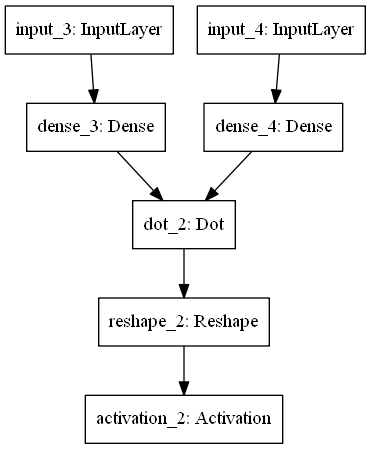

In [30]:
%%time
steps_perepoch = int( len(Wtr) / bs )

print('steps per epoch; %d' % steps_perepoch)

history = model.fit_generator(gen, steps_per_epoch=steps_perepoch,
                    epochs=3, verbose=1, validation_data =gen_val, validation_steps=steps_perepoch/15)

steps per epoch; 1621
Epoch 1/3
1621/1621 [==============================] - 5027s 3s/step - loss: 0.3196 - val_loss: 0.3101
Epoch 2/3
1621/1621 [==============================] - 4764s 3s/step - loss: 0.3057 - val_loss: 0.3043
Epoch 3/3
1621/1621 [==============================] - 4771s 3s/step - loss: 0.2975 - val_loss: 0.3009
Wall time: 4h 2min 44s


How long is 5027 seconds?

In [92]:
from datetime import datetime, timedelta
sec = timedelta(seconds=5027)
print("epoch time is roughly %s" % sec)

epoch time is roughly 1:23:47


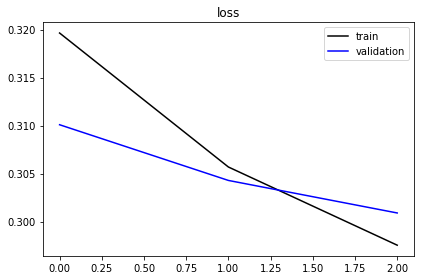

In [32]:
# plot loss function
plt.title("loss")
plt.plot(history.history["loss"], color="k", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

retrieve the weights from the first dense layer (embedding for the centre word). This will convert the input vector from a one-hot sum of two words to a dense 300 dimensional representation

Note that the weights matrix itself is not the word embeddings, to get word embeddings we need to multiply it with a one-hot word representation and add the bias 

In [33]:
# Weights and biases
W, b = model.layers[2].get_weights()

In [93]:
print( W.shape, b.shape )

(10000, 300) (300,)


You can programatically access the layers in a neural network in Keras

In [34]:
model.layers

For every word in the vocabulary, compute the word embedding using the weights and biases we learned in training and place it into a dictionary data structure

In [36]:
%%time

idx2emb = {}

for wid in range(vocab_size) | where( lambda i: i in reverse_word_index ):
    
    vec_in = ohe.fit_transform(wid).todense()

    idx2emb[wid] = vec_in*W+b

Wall time: 3min 4s


Now let's sanity check our word embeddings! For a few sample words let's find the other words which have the smallest cosine distance and assess if they are linguistically or semantically similar, note the corpus is IMDB so expect a "film" bias to the word vectors ;) 

Prima facie, these word vectors are pretty good!

In [47]:
for word in [ "film", "money", "american", "britain", "horror", "war", "office", "plane", "legal", "president"]:
    wid = word_index[word]
    source_emb = idx2emb[wid]
    distances = []
    for i in range(vocab_size) | where( lambda i: i in reverse_word_index ):
        if i == wid:
            continue
        target_emb = idx2emb[i]
        distances.append(((wid, i),
                         cosine_distances(source_emb, target_emb)))
    sorted_distances = sorted(distances, key=operator.itemgetter(1))[0:10]
    predictions = [reverse_word_index[x[0][1]] for x in sorted_distances]
    print("{:s} => {:s}".format(word, ", ".join(predictions)))

film => documentary, movie, caprica, expectation, taut, distribution, independent, accurately, kurosawa, offbeat
money => spend, pay, wasting, spare, ruin, spent, waste, cash, yourselves, advise
american => british, australian, indian, italian, horrors, zealand, americans, korean, immigrants, mythical
britain => colonial, referred, 1950, 1946, 1984, shamelessly, declares, 1960s, 30s, superstar
horror => genre, flicks, slasher, flick, gangster, 50's, spoof, indie, fare, movies
war => civil, wwii, russia, revolution, east, culture, latin, communist, colonial, horrors
office => notices, columbia, owned, florida, landing, jail, rivers, smash, justification, lure
plane => stops, crashing, landing, cloak, knocking, land, fence, dive, proceeds, bats
legal => anonymous, applied, secrets, declares, rotting, continuous, admitted, rampant, distinctive, speeches
president => witnesses, elected, raid, joins, cia, facing, officers, havoc, meanwhile, forces


Let's try running a tSNE projection of the word vectors into a 2d space and see what comes up. We will select 1000 non-frequent words which will hopefully show something instructive on the visualisation. As we can see, all the first names are clustered together at the bottom

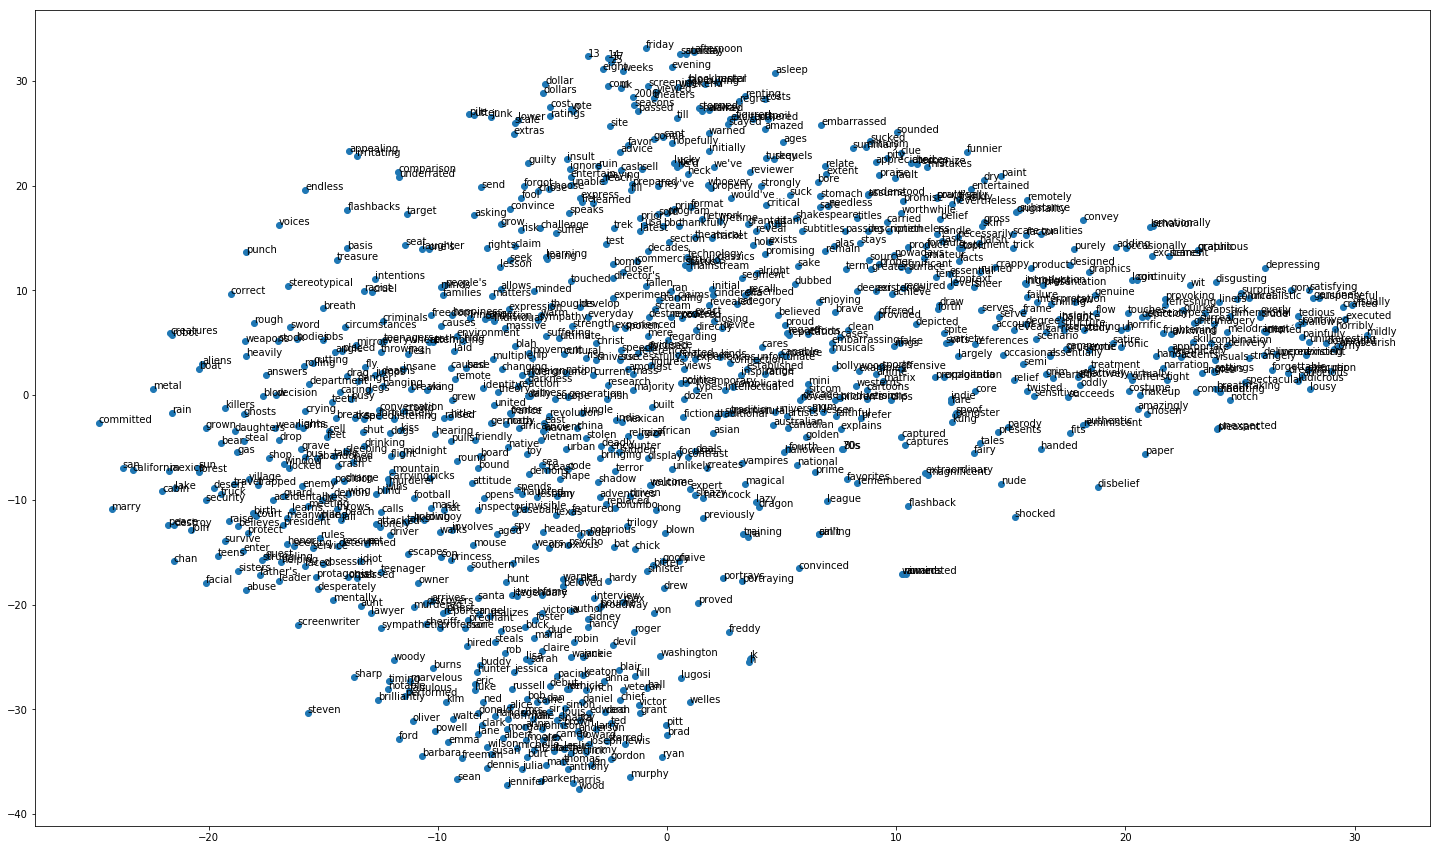

In [48]:
from sklearn.manifold import TSNE

w=1000
start_from=2000

WORDS = np.zeros( (w, dimensions) )

for i in range(0,w):
    WORDS[i] = idx2emb[start_from+i]
    
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(WORDS)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

fig = plt.gcf()
fig.set_size_inches(25,15)

for i, (x,y) in enumerate(zip(x_coords, y_coords)):
    plt.annotate(reverse_word_index[start_from+i], (x, y))

Let's export the word vectors so we can see them on https://projector.tensorflow.org i.e. 3d tSNE!

In [99]:
WORDS_ALL = np.zeros( (vocab_size, dimensions) )

for i in range(4,vocab_size):
    WORDS_ALL[i] = idx2emb[i]
    
np.savetxt("imdb_embeddings.csv", WORDS_ALL, delimiter="\t")

In [109]:
reverse_word_index[0]="unknown"
reverse_word_index[1]="unknown"
reverse_word_index[2]="unknown"
reverse_word_index[3]="unknown"

with open('labels.csv', 'w', encoding='utf-8') as f:
    for item in range(0,vocab_size) | select(lambda i: reverse_word_index[i]) | as_list:
        f.write("%s\n" % item)